In [44]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import *
import skimage
import os

# Define image and label path
image_path_S0_0 = 'C:/Users/brian/Documents/SPRING 2025/BMED 6780/Project/archive/openEDS/openEDS/S_0/0.png'
label_path_S0 = 'C:/Users/brian/Documents/SPRING 2025/BMED 6780/Project/archive/bbox/bbox/S_0.txt'
event_path_1 = 'archive/openeds-dataset/openEDS_events/openEDS_events/S_0/event_frames/1.npy' 

# --- Image Loading ---
try:
    image = Image.open(image_path_S0_0)
    image_np = np.array(image)
    height, width = image_np.shape
    print(f"Image loaded: {image_path_S0_0}, Shape: {image_np.shape}")
except Exception as e:
    print(f"Error loading image: {e}")

# --- Label Loading ---
lines = [] # Initialize empty list
try:
    # Use the correct variable name defined earlier
    with open(label_path_S0, 'r') as f:
        lines = f.readlines()
    print(f"Label file loaded: {label_path_S0}, Number of lines: {len(lines)}")
except Exception as e:
    print(f"Error loading label file: {e}")


Image loaded: C:/Users/brian/Documents/SPRING 2025/BMED 6780/Project/archive/openEDS/openEDS/S_0/0.png, Shape: (400, 640)
Label file loaded: C:/Users/brian/Documents/SPRING 2025/BMED 6780/Project/archive/bbox/bbox/S_0.txt, Number of lines: 156


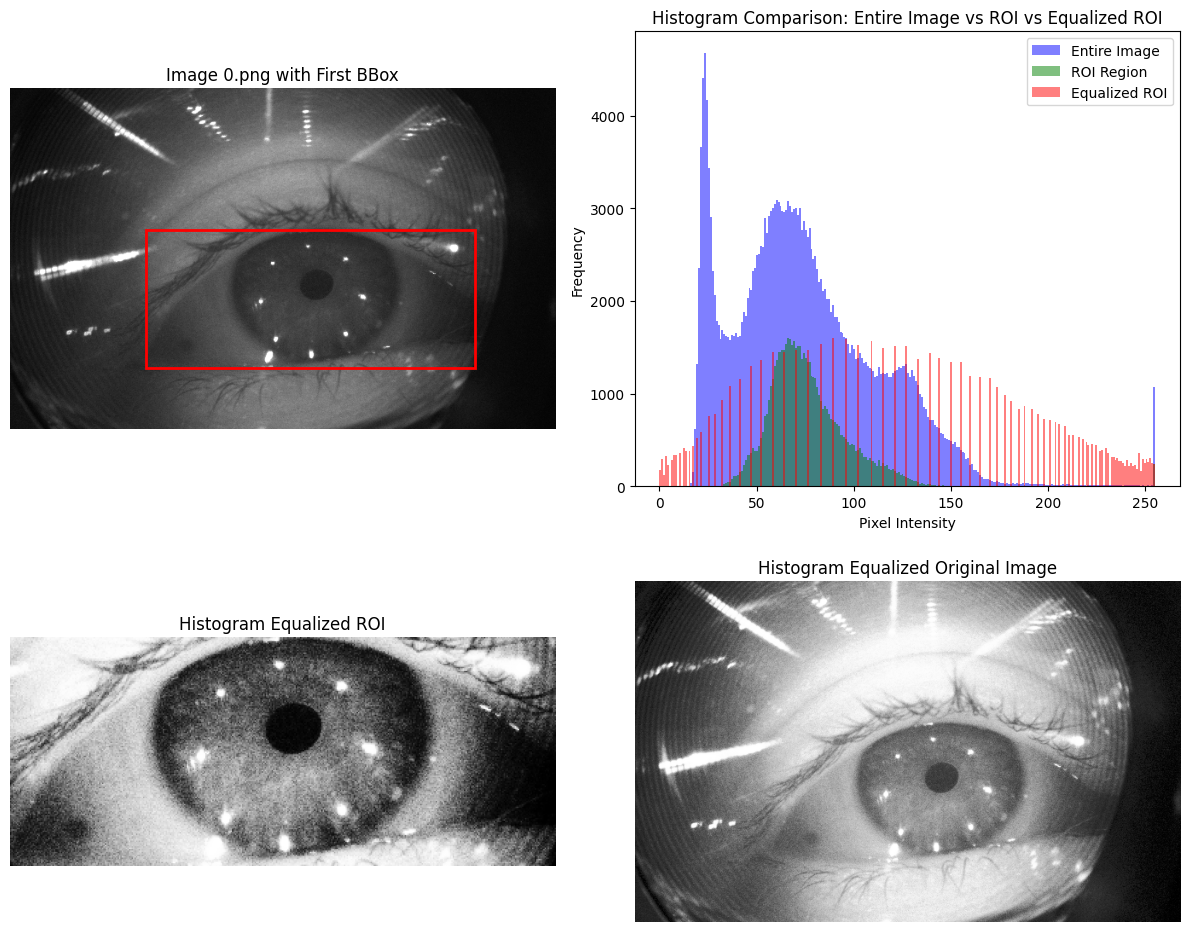

In [46]:
# --- Combined Plot: Image with ROI and Histograms ---
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot the image with the ROI
axs[0, 0].imshow(image_np, cmap='gray')
axs[0, 0].set_title(f"Image {os.path.basename(image_path_S0_0)} with First BBox")
axs[0, 0].axis('off')

if lines:
    first_line = lines[0]
    try:
        parts = first_line.strip().split()
        if len(parts) == 4:
            x_min, x_max, y_min, y_max = map(float, parts)
            w = x_max - x_min
            h = y_max - y_min
            w = min(width - x_min, w)
            h = min(height - y_min, h)

            # Draw the bounding box
            rect = plt.Rectangle((x_min, y_min), w, h, edgecolor='red', facecolor='none', linewidth=2)
            axs[0, 0].add_patch(rect)
        else:
            print("Warning: First line in label file does not have enough data.")
    except (ValueError, IndexError) as e:
        print(f"Warning: Could not parse bounding box from first line. Error: {e}")
else:
    print("Warning: Label file is empty or could not be read. No bounding box drawn.")

# Plot the histogram of the entire image and ROI region for comparison
axs[0, 1].hist(image_np.ravel(), bins=256, range=(0, 255), color='blue', alpha=0.5, label='Entire Image')
if lines:
    try:
        first_line = lines[0]
        parts = first_line.strip().split()
        if len(parts) == 4:
            x_min, x_max, y_min, y_max = map(float, parts)
            w = x_max - x_min
            h = y_max - y_min
            w = min(width - x_min, w)
            h = min(height - y_min, h)
            roi = image_np[int(y_min):int(y_min+h), int(x_min):int(x_min+w)]
            
            axs[0, 1].hist(roi.ravel(), bins=256, range=(0, 255), color='green', alpha=0.5, label='ROI Region')
            
            # Perform histogram equalization on the ROI
            roi_flat = roi.ravel()
            hist, bins = np.histogram(roi_flat, bins=256, range=(0, 255))
            cdf = hist.cumsum()
            cdf_normalized = cdf * 255 / cdf[-1]
            roi_equalized = np.interp(roi_flat, bins[:-1], cdf_normalized).reshape(roi.shape)
            
            # Plot the histogram of the equalized ROI
            axs[0, 1].hist(roi_equalized.ravel(), bins=256, range=(0, 255), color='red', alpha=0.5, label='Equalized ROI')
            
            # Add a subplot to display the histogram-equalized ROI
            axs[1, 0].imshow(roi_equalized, cmap='gray')
            axs[1, 0].set_title("Histogram Equalized ROI")
            axs[1, 0].axis('off')
        else:
            print("Cannot plot ROI histogram: insufficient data in the first line of the label file.")
    except Exception as e:
        print(f"Error plotting ROI histogram: {e}")
else:
    print("Cannot plot ROI histogram: label file is empty or not loaded.")


    # Perform histogram equalization on the entire image
image_flat = image_np.ravel()
hist, bins = np.histogram(image_flat, bins=256, range=(0, 255))
cdf = hist.cumsum()
cdf_normalized = cdf * 255 / cdf[-1]
image_equalized = np.interp(image_flat, bins[:-1], cdf_normalized).reshape(image_np.shape)

# Add a subplot to display the histogram-equalized original image
axs[1, 1].imshow(image_equalized, cmap='gray')
axs[1, 1].set_title("Histogram Equalized Original Image")
axs[1, 1].axis('off')

axs[0, 1].set_title("Histogram Comparison: Entire Image vs ROI vs Equalized ROI")
axs[0, 1].set_xlabel("Pixel Intensity")
axs[0, 1].set_ylabel("Frequency")
axs[0, 1].legend()

plt.tight_layout()
plt.show()

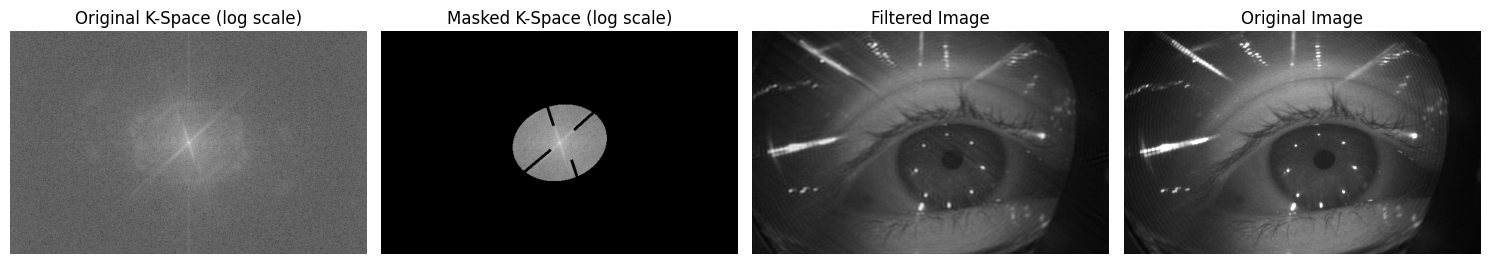

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose 'image_np' is your original 2D image array

# 1) Compute 2D Fourier Transform and shift zero-frequency to the center
k_space = np.fft.fftshift(np.fft.fft2(image_np))

# 2) Create a mask to remove frequencies in an elliptical band
rows, cols = image_np.shape
crow, ccol = rows // 2, cols // 2  # center of the frequency domain


# Define the semi-axes for the inner ellipse and the thickness
a_in = 95*0.9  # inner semi-major and semi-minor axes
b_in = 75*0.9
thickness = 320  # thickness of the elliptical band

# Calculate the outer semi-axes based on the thickness
a_out, b_out = a_in + thickness, b_in + thickness

# Define the rotation angle in radians
theta = np.radians(-15)  # Rotate by 30 degrees

# Build a 2D grid for the mask
y, x = np.ogrid[:rows, :cols]
x_rot = (x - ccol) * np.cos(theta) + (y - crow) * np.sin(theta)
y_rot = -(x - ccol) * np.sin(theta) + (y - crow) * np.cos(theta)

ellipse_inner = (x_rot / a_in) ** 2 + (y_rot / b_in) ** 2
ellipse_outer = (x_rot / a_out) ** 2 + (y_rot / b_out) ** 2

# Initialize a mask of all ones
mask = np.ones_like(image_np, dtype=np.float32)

# Set the mask to zero in the elliptical band region
mask[(ellipse_inner >= 1) & (ellipse_outer <= 1)] = 0

# Add a vertical line to the mask, offset upwards by 50
vertical_line_x = ccol  # x-coordinate of the vertical line
mask[:crow - 80, vertical_line_x - 1:vertical_line_x + 1] = 0

# Add another vertical line mirrored across the x-axis
mask[crow + 80:, vertical_line_x - 1:vertical_line_x + 1] = 0

# Add a rotated rectangle to the mask
rect_center_x, rect_center_y = 420, 110  # Center of the rectangle
rect_width, rect_height = 200, 5  # Width and height of the rectangle
rect_angle = np.radians(-42)  # Rotation angle in radians

# Create a grid for the rotated rectangle
x_rot_rect = (x - rect_center_x) * np.cos(rect_angle) + (y - rect_center_y) * np.sin(rect_angle)
y_rot_rect = -(x - rect_center_x) * np.sin(rect_angle) + (y - rect_center_y) * np.cos(rect_angle)

# Define the rectangle boundaries
rect_mask = (np.abs(x_rot_rect) <= rect_width / 2) & (np.abs(y_rot_rect) <= rect_height / 2)

# Apply the rectangle mask
mask[rect_mask] = 0

# Add a rotated rectangle to the mask
rect_center_x, rect_center_y = 170, 325  # Center of the rectangle
rect_width, rect_height = 350, 5  # Width and height of the rectangle
rect_angle = np.radians(-40)  # Rotation angle in radians

# Create a grid for the rotated rectangle
x_rot_rect = (x - rect_center_x) * np.cos(rect_angle) + (y - rect_center_y) * np.sin(rect_angle)
y_rot_rect = -(x - rect_center_x) * np.sin(rect_angle) + (y - rect_center_y) * np.cos(rect_angle)

# Define the rectangle boundaries
rect_mask = (np.abs(x_rot_rect) <= rect_width / 2) & (np.abs(y_rot_rect) <= rect_height / 2)

# Apply the rectangle mask
mask[rect_mask] = 0


# Add a rotated rectangle to the mask
rect_center_x, rect_center_y = 275, 65  # Center of the rectangle
rect_width, rect_height = 220, 5  # Width and height of the rectangle
rect_angle = np.radians(72)  # Rotation angle in radians

# Create a grid for the rotated rectangle
x_rot_rect = (x - rect_center_x) * np.cos(rect_angle) + (y - rect_center_y) * np.sin(rect_angle)
y_rot_rect = -(x - rect_center_x) * np.sin(rect_angle) + (y - rect_center_y) * np.cos(rect_angle)

# Define the rectangle boundaries
rect_mask = (np.abs(x_rot_rect) <= rect_width / 2) & (np.abs(y_rot_rect) <= rect_height / 2)

# Apply the rectangle mask
mask[rect_mask] = 0

# Add a rotated rectangle to the mask
rect_center_x, rect_center_y = 365, 335  # Center of the rectangle
rect_width, rect_height = 220, 5  # Width and height of the rectangle
rect_angle = np.radians(72)  # Rotation angle in radians

# Create a grid for the rotated rectangle
x_rot_rect = (x - rect_center_x) * np.cos(rect_angle) + (y - rect_center_y) * np.sin(rect_angle)
y_rot_rect = -(x - rect_center_x) * np.sin(rect_angle) + (y - rect_center_y) * np.cos(rect_angle)

# Define the rectangle boundaries
rect_mask = (np.abs(x_rot_rect) <= rect_width / 2) & (np.abs(y_rot_rect) <= rect_height / 2)

# Apply the rectangle mask
mask[rect_mask] = 0

# 3) Apply the mask in k-space
k_space_filtered = k_space * mask

# 4) Inverse FFT to get the filtered image
filtered_image = np.fft.ifft2(np.fft.ifftshift(k_space_filtered))
filtered_image = np.abs(filtered_image)  # Take magnitude if the result is complex

# 5) Display the results
fig, ax = plt.subplots(1, 4, figsize=(15, 4))

ax[0].imshow(np.log1p(np.abs(k_space)), cmap='gray')
ax[0].set_title('Original K-Space (log scale)')
ax[0].axis('off')

# Masked K-Space
ax[1].imshow(np.log1p(np.abs(k_space_filtered)), cmap='gray')
ax[1].set_title('Masked K-Space (log scale)')
ax[1].axis('off')

# Filtered Image
ax[2].imshow(filtered_image, cmap='gray')
ax[2].set_title('Filtered Image')
ax[2].axis('off')

# Original Image
ax[3].imshow(image_np, cmap='gray')
ax[3].set_title("Original Image")
ax[3].axis('off')

plt.tight_layout()
plt.show()